In [34]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler


In [35]:
#raw_tracking_data = pd.read_csv("tracking_week_1.csv")
raw_tracking_data = pd.concat([pd.read_csv(f'tracking_week_{week}.csv') for week in range(1, 10)])


In [36]:
tracking_data = raw_tracking_data[raw_tracking_data['displayName'] != 'football']
tracking_data['tackle_label'] = tracking_data.groupby(['playId','gameId'])['event'].transform(lambda x: int(any(event == 'tackle' for event in x)))

#tracking_data.head(1000).to_csv('week1_sample.csv', index=False)
#tracking_data.to_csv('week1.csv', index=False)


/var/folders/p5/6yg2mqv54t94ck39knmnt8780000gn/T/ipykernel_15919/1927298155.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tracking_data['tackle_label'] = tracking_data.groupby(['playId','gameId'])['event'].transform(lambda x: int(any(event == 'tackle' for event in x)))


In [ ]:
tracking_data


In [37]:
import numpy as np

def reverse_deg(deg):
    if deg < 180:
        return deg + 180
    if deg >= 180:
        return deg - 180


In [38]:
tracking_data["o_standard"]=np.where(tracking_data["playDirection"] == "left", tracking_data["o"].apply(reverse_deg), tracking_data["o"])

tracking_data["dir_standard"] = np.where(tracking_data["playDirection"] == "left", tracking_data["dir"].apply(reverse_deg), tracking_data["dir"])

tracking_data["x_standard"] = np.where(tracking_data["playDirection"] == "left", tracking_data["x"].apply(lambda x: 120 - x), tracking_data["x"])

tracking_data["y_standard"] =np.where(tracking_data["playDirection"] == "left",  tracking_data["y"].apply(lambda y: 160/3 - y), tracking_data["y"])


/var/folders/p5/6yg2mqv54t94ck39knmnt8780000gn/T/ipykernel_15919/215362370.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tracking_data["o_standard"]=np.where(tracking_data["playDirection"] == "left", tracking_data["o"].apply(reverse_deg), tracking_data["o"])
/var/folders/p5/6yg2mqv54t94ck39knmnt8780000gn/T/ipykernel_15919/215362370.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tracking_data["dir_standard"] = np.where(tracking_data["playDirection"] == "left", tracking_data["dir"].apply(reverse_de

In [ ]:
tracking_data


In [39]:
plays = pd.read_csv("plays.csv")


In [40]:
merged_data = pd.merge(tracking_data, plays, on=['gameId', 'playId'])


In [41]:
# Calculate acceleration in x-direction
merged_data['acceleration_x'] = merged_data['a'] * np.cos(np.deg2rad(merged_data['dir_standard']))
# Calculate acceleration in y-direction
merged_data['acceleration_y'] = merged_data['a'] * np.sin(np.deg2rad(merged_data['dir_standard']))


In [ ]:
merged_data


In [ ]:
merged_data.columns


In [42]:
def create_heatmap(data, feature, size=(120, 53)):
    heatmap = np.zeros(size)
    for _, row in data.iterrows():
        x = min(int(row['x']), size[0] - 1)
        y = min(int(row['y']), size[1] - 1)
        heatmap[x, y] += int(row[feature]) if feature in row and pd.notnull(row[feature]) else 0
    return MinMaxScaler().fit_transform(heatmap)


In [43]:
def generate_multi_channel_heatmaps(df, game_id, play_id, tracking_data):
    player_data = df[(df['gameId'] == game_id) & (df['playId'] == play_id)] #& (df['frameId'] == frame_id)]
    features = ['acceleration_x', 'acceleration_y', 's','dis']
    ball_features = ['a', 's','dis']
    heatmaps = []

    offense_data = player_data[(player_data['possessionTeam'] == player_data['club']) & (player_data['nflId'] != player_data['ballCarrierId'])]
    defense_data = player_data[player_data['defensiveTeam'] == player_data['club']]
    ball_carrier_data = player_data[player_data['nflId'] == player_data['ballCarrierId']]
    ball_data = tracking_data[(tracking_data['gameId'] == game_id) & (tracking_data['playId'] == play_id) & (tracking_data['displayName'] == 'football')]


    for feature in features:

        heatmaps.append(create_heatmap(defense_data, feature))
        heatmaps.append(create_heatmap(offense_data, feature))
        heatmaps.append(create_heatmap(ball_carrier_data, feature))

    for feature in ball_features:
        heatmaps.append(create_heatmap(ball_data, feature))


    return np.stack(heatmaps, axis=-1)


In [44]:
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split

X_heatmaps = []
y_labels = []

for (gameId,play_id), group in merged_data.groupby(['gameId','playId']):
    heatmaps = generate_multi_channel_heatmaps(merged_data, gameId,play_id,raw_tracking_data)
    X_heatmaps.append(heatmaps)
    y_labels.append(group['tackle_label'].iloc[0])

X_heatmaps = np.array(X_heatmaps)
y_labels = np.array(y_labels)

y_labels_encoded = to_categorical(y_labels)

X_train, X_test, y_train, y_test = train_test_split(X_heatmaps, y_labels_encoded, test_size=0.2, random_state=42)


2023-12-03 21:58:17.380911: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [ ]:
#selected_gameIds


In [ ]:
import numpy as np
# Specify the file path to save the data
file_path = "X_heatmaps.npy"
# Save the X_heatmaps data to the file
np.save(file_path, X_heatmaps)


In [52]:
from keras.models import Model
from keras.models import Sequential
from sklearn.preprocessing import StandardScaler
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, Flatten, concatenate, Dropout

def build_cnn_model(input_shape):
    model = Sequential()
    model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(2, activation='softmax'))
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

input_shape = X_train.shape[1:]
model = build_cnn_model(input_shape)
model.summary()


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 118, 51, 32)       4352      
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 59, 25, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_7 (Conv2D)           (None, 57, 23, 64)        18496     
                                                                 
 max_pooling2d_7 (MaxPoolin  (None, 28, 11, 64)        0         
 g2D)                                                            
                                                                 
 flatten_3 (Flatten)         (None, 19712)             0         
                                                                 
 dense_6 (Dense)             (None, 128)              

Epoch 1/100
90/90 [==============================] - 39s 423ms/step - loss: 0.4694 - accuracy: 0.8000 - val_loss: 0.4091 - val_accuracy: 0.8198
Epoch 2/100
90/90 [==============================] - 36s 401ms/step - loss: 0.3498 - accuracy: 0.8359 - val_loss: 0.3265 - val_accuracy: 0.8388
Epoch 3/100
90/90 [==============================] - 35s 390ms/step - loss: 0.3006 - accuracy: 0.8598 - val_loss: 0.2958 - val_accuracy: 0.8679
Epoch 4/100
90/90 [==============================] - 35s 384ms/step - loss: 0.2800 - accuracy: 0.8718 - val_loss: 0.2928 - val_accuracy: 0.8649
Epoch 5/100
90/90 [==============================] - 35s 386ms/step - loss: 0.2544 - accuracy: 0.8875 - val_loss: 0.2872 - val_accuracy: 0.8679
Epoch 6/100
90/90 [==============================] - 36s 401ms/step - loss: 0.2262 - accuracy: 0.9005 - val_loss: 0.2919 - val_accuracy: 0.8729
Epoch 7/100
90/90 [==============================] - 35s 389ms/step - loss: 0.1991 - accuracy: 0.9121 - val_loss: 0.2849 - val_accuracy:

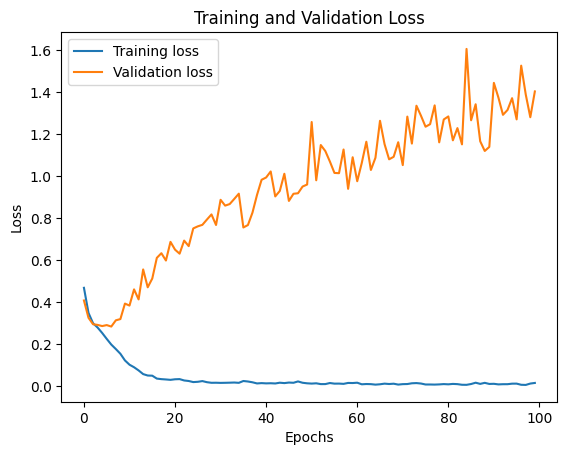

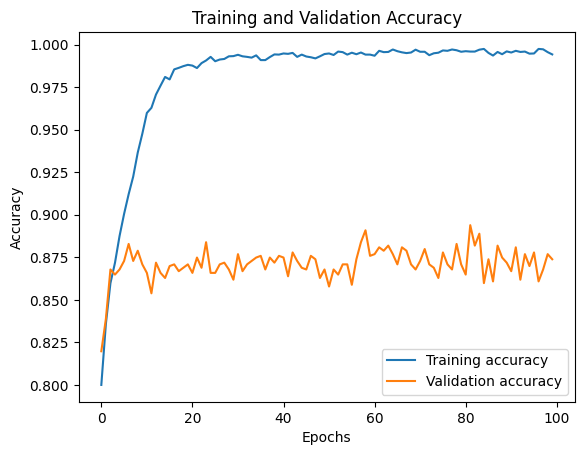

In [51]:
from keras.callbacks import History
import matplotlib.pyplot as plt

history = model.fit(X_train, y_train, batch_size=100, epochs=100, validation_split=0.1)

test_loss, test_acc = model.evaluate(X_test, y_test)
print(f'Test accuracy: {test_acc}')

plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.plot(history.history['accuracy'], label='Training accuracy')
plt.plot(history.history['val_accuracy'], label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


In [53]:
model.fit(X_train, y_train, batch_size=500, epochs=20, validation_split=0.1)
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f'Test accuracy: {test_acc}')


Epoch 1/20
18/18 [==============================] - 39s 2s/step - loss: 0.7345 - accuracy: 0.7467 - val_loss: 0.4839 - val_accuracy: 0.7918
Epoch 2/20
18/18 [==============================] - 37s 2s/step - loss: 0.4559 - accuracy: 0.8032 - val_loss: 0.4476 - val_accuracy: 0.7908
Epoch 3/20
18/18 [==============================] - 35s 2s/step - loss: 0.4325 - accuracy: 0.8049 - val_loss: 0.4286 - val_accuracy: 0.7928
Epoch 4/20
18/18 [==============================] - 35s 2s/step - loss: 0.4143 - accuracy: 0.8093 - val_loss: 0.4076 - val_accuracy: 0.8078
Epoch 5/20
18/18 [==============================] - 36s 2s/step - loss: 0.3896 - accuracy: 0.8196 - val_loss: 0.3771 - val_accuracy: 0.8208
Epoch 6/20
18/18 [==============================] - 36s 2s/step - loss: 0.3586 - accuracy: 0.8242 - val_loss: 0.3512 - val_accuracy: 0.8348
Epoch 7/20
18/18 [==============================] - 37s 2s/step - loss: 0.3297 - accuracy: 0.8325 - val_loss: 0.3333 - val_accuracy: 0.8458
Epoch 8/20
18/18 [==

In [49]:
len(X_heatmaps)


12483